In [188]:
import numpy as np
import csv
import math
import pandas as pd
from sklearn import preprocessing
from sklearn import datasets
from sklearn import cluster
import matplotlib.pyplot as plt
import itertools
from sklearn import linear_model
from scipy.optimize import minimize
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import norm
import random
import matplotlib.pyplot as plt
import time

In [189]:
# read dataset
user_history = pd.read_csv("user_history.csv")
user_ratings = pd.read_csv("user_ratings.csv")

In [190]:
# encode users as indices
le_user = preprocessing.LabelEncoder()
le_user.fit(user_history['USER ID'])

user_with_rating_index = le_user.transform(user_ratings['USER ID'])
all_user_index = le_user.transform(user_history['USER ID'])
user_ratings['USER INDEX'] = user_with_rating_index
user_ratings

# encode products as indices
le_product = preprocessing.LabelEncoder()
le_product.fit(user_ratings['PRODUCT'])

product_ID = le_product.transform(user_ratings['PRODUCT'])
user_ratings['PRODUCT ID'] = product_ID
user_ratings

,USER ID,PRODUCT,RATING,USER INDEX,PRODUCT ID
0,100950,secret postage,4,0,54
1,100950,violet saga,4,0,70
2,100950,pepper chicago,3,0,41
3,100950,nina sailor,2,0,35
4,100950,front salami,3,0,18
...,...,...,...,...,...
33720,117449,garden jimmy,4,2999,19
33721,117449,evita soviet,8,2999,16
33722,117449,tourist micro,7,2999,65
33723,117449,diploma moment,7,2999,14


In [191]:
#display full dataset
user_ratings_table = pd.pivot_table(user_ratings,values='RATING', index='USER ID',
                    columns='PRODUCT')
user_ratings_table


PRODUCT,adrian crater,anagram mentor,apropos pizza,bandit anatomy,banjo ladder,barcode arnold,bazooka diagram,bronze mystic,calypso zigzag,casino unit,...,tourist micro,tripod stand,update lola,ventura puzzle,viking llama,violet saga,vista queen,viva avalon,voodoo planet,wheel gibson
USER ID,,,,,,,,,,,,,,,,,,,,,
100950,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
100956,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100969,NaN,10.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,0.0,NaN,NaN,8.0,2.0
100974,NaN,NaN,NaN,9.0,NaN,5.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117440,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,6.0,NaN,NaN,NaN,NaN,NaN,5.0
117442,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
117446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
#convert the data frame to a matrix and replace nan with zeros
userR = user_ratings_table.fillna(0)
userR = userR.to_numpy()
#userR = user_ratings_table.to_numpy()
#fill entries with nan by 0
#for i in range (len(userR)):
    #for j in range (len(userR[0])):
        #if (math.isnan(userR[i,j])):
            #userR[i,j] = 0
userR

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 9., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [193]:
#Find duplicates ID that exist in both history and ratings
duplicates = pd.merge(user_history["USER ID"], user_ratings["USER ID"], how='outer', indicator='Exist')
duplicates = duplicates.loc[duplicates['Exist'] == 'both']
duplicates

,USER ID,Exist
0,100950,both
1,100950,both
2,100950,both
3,100950,both
4,100950,both
...,...,...
33720,117449,both
33721,117449,both
33722,117449,both
33723,117449,both


In [194]:
#keep only IDs that exist in both dataset in history
user_his = user_history[user_history["USER ID"].isin(duplicates["USER ID"])]
user_his = pd.DataFrame(user_his)
user_his
userR[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

Coefficients: 
 [-1.69755183 -0.1444432   0.10181845  0.19597968  0.09539496 -0.08105605
  0.05950732 -0.22414969 -0.28908323 -0.18130868 -0.01906144 -0.07086536
 -0.07348136 -0.00201981  0.14473785  0.44640367 -0.40949357 -0.03406032
 -0.13470133  0.05710739 -0.02979186  0.30762638 -0.18222989  0.11309605
 -0.08163071 -0.29514803 -0.15157339  0.09087489  0.01220497  0.02961635
 -0.3125126   0.33218946 -0.19827126 -0.07777534 -0.23884043  0.2404062
 -0.41499705 -0.04341416  0.02121393  0.04571253  0.16726707 -0.20455777
 -0.00686795 -0.17531112 -0.1635322   0.31216798 -0.10822943  0.1819334
  0.13214244  0.26593036  0.08238676  0.15693322 -0.12157991 -0.14494631
  0.08868402 -0.34273331 -0.25543359  0.15298219  0.02062192  0.05746927
  0.02653454  0.18607608 -0.28852186  0.21246175 -0.07179278 -0.11133598
  0.0036206   0.12022897  0.03407441  0.07046424  0.08302584  0.23470522
 -0.00251308 -0.1370842  -0.09697573  0.25934325 -0.02122403  0.1049367
  0.1506157   0.24531175 -0.03993408 -

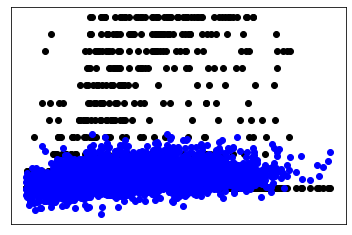

In [195]:
#fit regression model
y = userR[:,0] #set y, you can change columns of userR to fit each product to a regression model
user_hisw = user_his.drop(['USER ID'],axis=1)
n,p = user_hisw.shape
X = np.ones((n, p + 1)) #add intercept
X[:, 1:] = user_hisw
#compute betahat
U, S, Vt = np.linalg.svd(X.T @ X)
betat = Vt.T @ (U.T @ (X.T @ y) / S)
betat
# compute predictions
y_pred = X @ betat
# compute MSE
MSE = np.mean((y - y_pred) ** 2)

# The coefficients
print('Coefficients: \n', betat)
# The mean squared error
print('Mean squared error: ', MSE)

#plot the output
plt.scatter(X[:, 3], y,  color='black')
plt.plot(X[:, 3], y_pred, 'ob')

plt.xticks(())
plt.yticks(())

plt.show()

In [220]:
def MSE(U, V, M, obs):
    s = 0
    st = 0
    nSamp = len(obs)
    for l in range(nSamp):
        i, j = obs[l]
        s += (np.dot(U[i, :], V[j, :].T) - M[i, j])**2
    return np.sqrt(s)

# compute relative Frobenius error: NORM(UV-M, 'fro')/NORM(M, 'fro')
def RelError(U, V, M, obs):
    s = 0
    st = 0
    nSamp = len(obs)
    for l in range(nSamp):
        i, j = obs[l]
        s += (np.dot(U[i, :], V[j, :].T) - M[i, j])**2
        st += (M[i, j])**2
    return np.sqrt(s)/np.sqrt(st)

In [221]:
M = user_ratings.pivot(index='USER INDEX', columns='PRODUCT ID', values='RATING').values

user_ratingsS = user_ratings.sort_values(["USER INDEX","PRODUCT ID"])
users = user_ratingsS['USER INDEX'].values
movies = user_ratingsS['PRODUCT ID'].values
ratings = user_ratingsS['RATING'].values
obs = [(users[i], movies[i]) for i in range(len(users))]
M = sparse.coo_matrix((ratings, (users,movies))).tocsr()


In [227]:

epoch = 100

alpha = 0.1 # step size (learning rate)
beta = 0.001 # regularization

nSamp = len(obs) # size of the observed set

np.random.shuffle(obs)

# form training and test sets (hyperparameter)
train = obs[1:(int)(np.floor(0.7*nSamp))] # training set [70%]
test = obs[(int)(np.floor(0.7*nSamp)):len(obs)+1] # test set [30%]

start = time.time()

# start SGD

k = 20 # guess of the rank of matrix

# initialize matrices
U = np.random.normal(size=(np.max(users)+1, k), scale=1/k)
V = np.random.normal(size=(np.max(movies)+1, k), scale=1/k)

errorVec = np.zeros((2, epoch), dtype='float')

RelErr_prev = 1
for itr in range(epoch):
    np.random.shuffle(train)
    selected_updates = train[1:(int)(np.floor(0.1*len(train)))] # batch size (hyperparameter) [10%]
    
    for l in selected_updates:
        i, j = l
        error = ( np.dot(U[i, :], V[j, :].T) - M[i, j] )
        U_temp = np.copy(U[i, :])
        # update U
        U[i, :] -= alpha * (error*V[j, :] + beta*U[i, :])
        # update V
        V[j, :] -= alpha * (error*U_temp + beta*V[j, :])

    errorVec[0, itr] = MSE(U, V, M, test)
    errorVec[1, itr] = RelError(U, V, M, test)

    # print errors during iteration
    if RelErr_prev - errorVec[1, itr] < 0.001:
        break
    else:
        print("iter", itr+1,
              ": MSE =", errorVec[0, itr],
              ", RelErr =", errorVec[1, itr])
        RelErr_prev = errorVec[1, itr]

end = time.time()
print("\nRunning time:", end-start)

iter 1 : MSE = 571.4708499974315 , RelErr = 0.9971339411283794
iter 2 : MSE = 500.41684224475 , RelErr = 0.8731549791503254
iter 3 : MSE = 466.5355449382196 , RelErr = 0.8140370179910557

Running time: 2.019975185394287


In [228]:
print(np.dot(U, V.T))

[[ 0.51105333  0.11901093 -0.68200064 ... -1.57255043 -1.34516752
  -0.68207115]
 [-0.1499277   0.24183055  0.25434847 ...  0.39678071  0.02876094
   0.5969718 ]
 [ 0.47392912  0.09900024  0.69460444 ...  0.88445275  0.04267366
   0.88617873]
 ...
 [ 1.03647195  2.45029065  4.01622664 ...  3.64944211  6.92647112
   4.85629532]
 [ 1.24797767  1.07917723  1.37939259 ...  1.32968651  3.12068732
   2.33865663]
 [ 0.12759384 -0.28378747 -0.0482341  ... -0.09058371 -0.35969724
  -0.7251075 ]]
